In [1]:
from utility import *
from models import * 
from dataloader import *
my_module_path = os.path.join("../", '21cm-wrapper')
sys.path.append(my_module_path)
from Leaf import *

device = 'cpu'

#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism

CUDA is available:  True


In [22]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)

|                                        | ▁▃▅ 0/5 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 5/5 [100%] in 1:00.0 (0.08/s)        


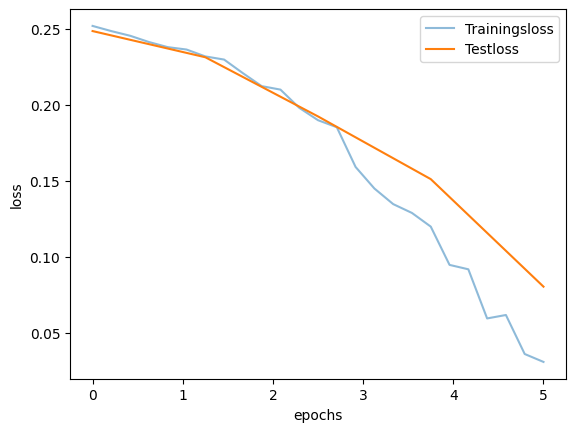

In [23]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [21]:
for x,y,_ in dataset_test:
    print(x.shape, y.shape)
    break

torch.Size([6]) torch.Size([1, 28, 28, 470])


In [7]:
# hyperparams
data_path = "/home/deck/Documents/masterstuff/data/datax5/"
batch_size = 8
epochs = 120
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=train_dataloader, Test_data=test_dataloader, device=device)

In [8]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.path + file)
/home/deck/Documents/masterstu

torch.Size([8, 6]) torch.Size([8, 1, 28, 28, 470])


In [4]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net2.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none'
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=10,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)

    x = x.to(device)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NPE_{i}.png", dpi=300)

/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Model.load_state_dict(torch.load(name, map_location=torch.dev

torch.Size([1, 6]) torch.Size([1])


on 0: /home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 6])) that is different to the input size (torch.Size([8, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
        return F.mse_loss(input, target, reduction=self.reduction)


on 1265: /home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([6, 1, 6])) that is different to the input size (torch.Size([6, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
           return F.mse_loss(input, target, reduction=self.reduction)


on 1266: test_loss_density_net[-1]=1.0051854844634414 test_loss_summary_net[-1]=0.08137927378745789
|████████████████████████████████████████| 1266 in 6:43.8 (3.14/s)              


AssertionError: The trailing dimensions of `theta_or_x` do not match the `event_shape`.

In [6]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

on 0: /home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 6])) that is different to the input size (torch.Size([8, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
        return F.mse_loss(input, target, reduction=self.reduction)


|⚠︎                                       | (!) 0/120 [0%] in 2.5s (0.00/s)      


KeyboardInterrupt: 

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

loss: 9771.8095703125
 pred: tensor([[4.7056e+00, 2.0909e-01, 4.1509e+01, 9.7214e+02, 5.0531e+00, 1.9355e+02],
        [3.2670e+00, 3.0016e-01, 4.0285e+01, 2.0903e+02, 4.9114e+00, 2.1090e+02],
        [6.4987e+00, 3.5049e-01, 3.9270e+01, 7.9099e+02, 4.4319e+00, 2.7894e+01],
        [6.2723e+00, 2.3508e-01, 3.9357e+01, 1.3976e+02, 5.1864e+00, 1.0977e+02],
        [5.5044e+00, 2.2245e-01, 3.9430e+01, 9.9683e+02, 4.3380e+00, 7.5367e+01],
        [4.3802e+00, 3.3234e-01, 4.1685e+01, 1.1081e+03, 4.9861e+00, 9.9697e+01],
        [4.2998e+00, 2.6039e-01, 4.1193e+01, 9.4134e+02, 5.1101e+00, 1.4847e+02],
        [4.0433e+00, 2.7417e-01, 4.1350e+01, 1.1188e+03, 4.9679e+00, 1.9201e+02]])
 truth: tensor([[8.6254e+00, 2.0445e-01, 4.1475e+01, 1.0218e+03, 4.9343e+00, 2.0373e+02],
        [1.4387e+00, 2.5871e-01, 4.0479e+01, 1.9545e+02, 4.9306e+00, 2.0469e+02],
        [9.9281e+00, 3.7896e-01, 3.8860e+01, 1.2317e+03, 4.0699e+00, 2.0282e+01],
        [7.7567e+00, 2.4295e-01, 3.9419e+01, 2.9904e+02, 5.1

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

Set initial parameters...


In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

Drawing 5000 posterior samples: 5009it [00:03, 1262.64it/s]                          


|                                        | ▂▄▆ 0/5000 [0%] in 0s (~0s, 0.0/s) 

Process SpawnProcess-8:
Traceback (most recent call last):
Process SpawnProcess-9:
Traceback (most recent call last):
Process SpawnProcess-10:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args,

on 0: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x705fb3fc3240>


on 0: Traceback (most recent call last):
  File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()


on 0:   File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)


on 0:   File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)


on 0:           ^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):


on 0:            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/connection.py", line 935, in wait
    ready = selector.select(timeout)


on 0:             ^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)


on 0:                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0: KeyboardInterrupt:


|⚠︎                                       | (!) 0/5000 [0%] in 8.2s (0.00/s)     


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

|                                        | ▁▃▅ 0/68 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 68/68 [100%] in 3.6s (19.17/s)       
 Training neural network. Epochs trained: 27

|████████████████████████████████████████| 4/4 [100%] in 0.4s (8.11/s)          




Generating 10 MCMC inits with 10

Generating 10 MCMC inits with 10
                         workers.: 100%|██████████| 10/10 [00:00<00:00, 52.34it/s]


















































































































































































































































































































































































































































































































































































































































































































































































































































































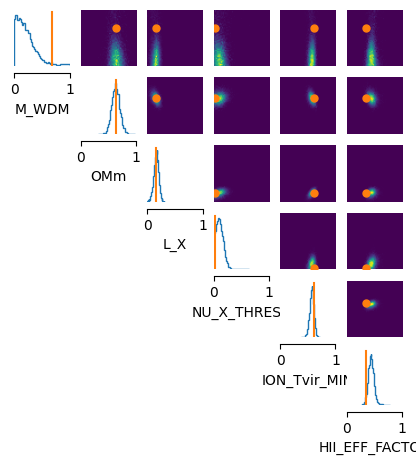

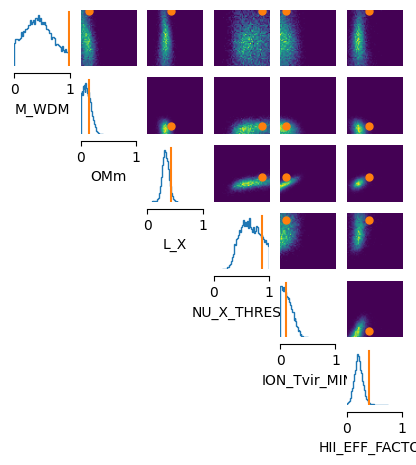

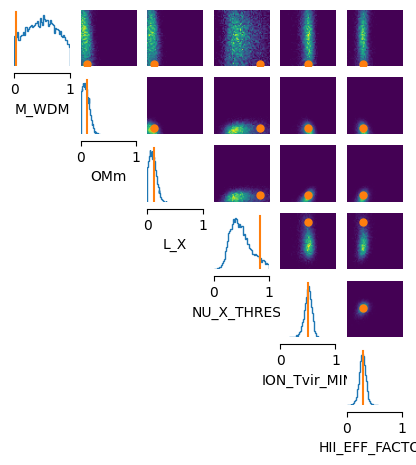

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

torch.Size([1, 1, 40, 40, 600])


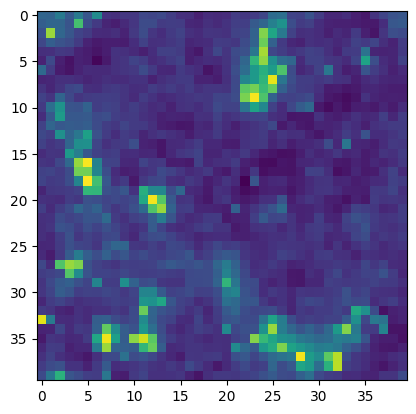

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

19 ms ± 223 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test = 0 if 0 == 1 elif

tensor([[5.9217e+00, 2.7670e-01, 3.8726e+01, 1.2436e+03, 4.0089e+00, 1.0010e+02],
        [4.2041e+00, 2.6606e-01, 3.9172e+01, 1.4720e+03, 5.0995e+00, 1.9095e+02],
        [4.7895e+00, 3.0926e-01, 4.0212e+01, 1.5779e+02, 4.8395e+00, 2.4750e+02],
        [3.5780e+00, 1.9815e-01, 3.8804e+01, 1.3745e+03, 4.3869e+00, 1.4221e+02],
        [7.3720e+00, 2.2123e-01, 3.9222e+01, 1.3777e+03, 4.2282e+00, 9.7412e+01],
        [9.8951e+00, 2.8068e-01, 3.9821e+01, 1.0525e+03, 4.3870e+00, 1.4162e+02],
        [6.2702e+00, 3.7933e-01, 3.9238e+01, 1.3620e+03, 5.2352e+00, 7.8885e+01],
        [4.0333e+00, 3.2795e-01, 3.8614e+01, 3.5615e+02, 4.7485e+00, 2.2162e+02],
        [6.2316e+00, 2.6243e-01, 3.9077e+01, 1.4615e+03, 4.6586e+00, 9.4448e+01],
        [8.8193e-01, 3.9259e-01, 4.1729e+01, 4.1617e+02, 4.9176e+00, 1.3069e+02],
        [6.5229e+00, 3.7412e-01, 4.0628e+01, 1.0993e+02, 4.7226e+00, 2.2049e+02],
        [5.1963e-01, 3.7171e-01, 3.9748e+01, 5.6189e+02, 4.8741e+00, 1.5590e+02],
        [8.4533e

In [ ]:
test = np.array([1,2,3,4])
for i in test:
    i = 1
print(test)

[1 2 3 4]


array([[[ 2.16423188e+00,  1.87341755e+00,  5.75007882e-01,
          2.86874169e+00, -1.15937351e-01,  5.44303631e-02,
          1.45522656e-01,  1.05337708e+00, -1.05117859e+00,
          2.14033277e+00],
        [ 1.64891759e+00, -3.55443309e-01,  1.55127590e+00,
          1.30877721e+00,  2.90344054e+00,  2.32347338e+00,
          1.74240246e+00, -9.74576609e-01,  1.25146355e+00,
          2.80247859e-01],
        [ 1.69863298e-01,  7.15945241e-01,  1.34308356e+00,
          5.47627998e-01,  1.59777303e+00,  3.30012578e-01,
          1.11721595e+00,  1.50978188e+00,  1.48424673e+00,
          1.33110040e+00],
        [-2.14562362e-01,  2.82336382e+00,  9.97008729e-01,
          2.04078661e-01,  8.54261767e-01,  1.28212417e+00,
         -1.19863010e-01,  1.37400610e+00,  2.73213483e+00,
          2.43111155e+00],
        [ 9.48636881e-02,  3.14118230e-01, -4.30816210e-01,
         -6.13428629e-02,  1.22780894e+00,  6.04426193e-01,
          1.22064712e+00,  1.68455613e+00,  8.101970

tensor([0.4499, 0.7471, 0.6653, 0.4028])